In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache
import psytrack as psy

sns.set_style('ticks')

In [69]:
drive_dir = "/Volumes/Brain2024"
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=drive_dir, use_static_cache=True)
behavior_session_id = 1053960987
behavior_session = cache.get_behavior_session(behavior_session_id)

/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [70]:
behavior_session.rewards

,volume,timestamps,auto_rewarded
0,0.005,44.87655,True
1,0.005,64.39291,True
2,0.005,80.90632,True
3,0.003,119.55534,False
4,0.003,130.28088,False
...,...,...,...
137,0.003,3522.61835,False
138,0.003,3534.59474,False
139,0.003,3566.17148,False
140,0.003,3591.60942,False


In [71]:
licks = behavior_session.licks

In [72]:
import src_local.get_metrics as get_metrics

In [73]:
licks_annot = get_metrics.annotate_licks(licks, behavior_session)

In [74]:
licks_annot[licks_annot['bout_rewarded']].head()

,timestamps,frame,pre_ili,post_ili,bout_start,bout_end,bout_number,rewarded,num_rewards,bout_rewarded,bout_num_rewards
7,45.53275,1279,6.26005,0.13111,True,False,6,True,1,True,1
8,45.66386,1287,0.13111,0.17113,False,False,6,False,0,True,1
9,45.83499,1297,0.17113,0.11008,False,False,6,False,0,True,1
10,45.94507,1304,0.11008,0.17815,False,False,6,False,0,True,1
11,46.12322,1314,0.17815,0.15011,False,False,6,False,0,True,1


In [75]:
stimulus_presentations = behavior_session.stimulus_presentations
stimulus_presentations = stimulus_presentations[stimulus_presentations['active']]
stim_table = get_metrics.annotate_bouts(licks_annot, stimulus_presentations)

In [76]:
stim_table.columns

Index(['stimulus_block', 'image_name', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'flashes_since_change', 'trials_id', 'active', 'contrast',
       'orientation', 'stimulus_index', 'rewarded', 'position_x',
       'spatial_frequency', 'temporal_frequency', 'is_sham_change',
       'stimulus_name', 'color', 'position_y', 'bout_start', 'num_bout_start',
       'bout_number', 'bout_end', 'num_bout_end', 'in_lick_bout', 'licked'],
      dtype='object')

In [77]:
stim_table['hits']   =  \
    stim_table['licked'] & \
    stim_table['is_change']
stim_table['misses'] = \
    ~stim_table['licked'] & \
    stim_table['is_change']
stim_table['aborts'] =  \
    stim_table['licked'] & \
    ~stim_table['is_change']

In [78]:
format_options = {
                  'mean_center':1, 
                  'timing_params': [-5,4],
                  'num_cv_folds': 10}

In [79]:
import src_local.format_Xy as format_Xy

In [80]:
psydata = format_Xy.build_regressor(stim_table, format_options, behavior_session)

In [81]:
psydata['inputs'].keys()

dict_keys(['task', 'omissions', 'omissions1', 'timing1D', 'bias'])

In [82]:
import src_local.psy_funcs as psy_funcs

{'bias': 1, 'timing1D': 1, 'omissions1': 1, 'task': 1, 'omissions': 1}


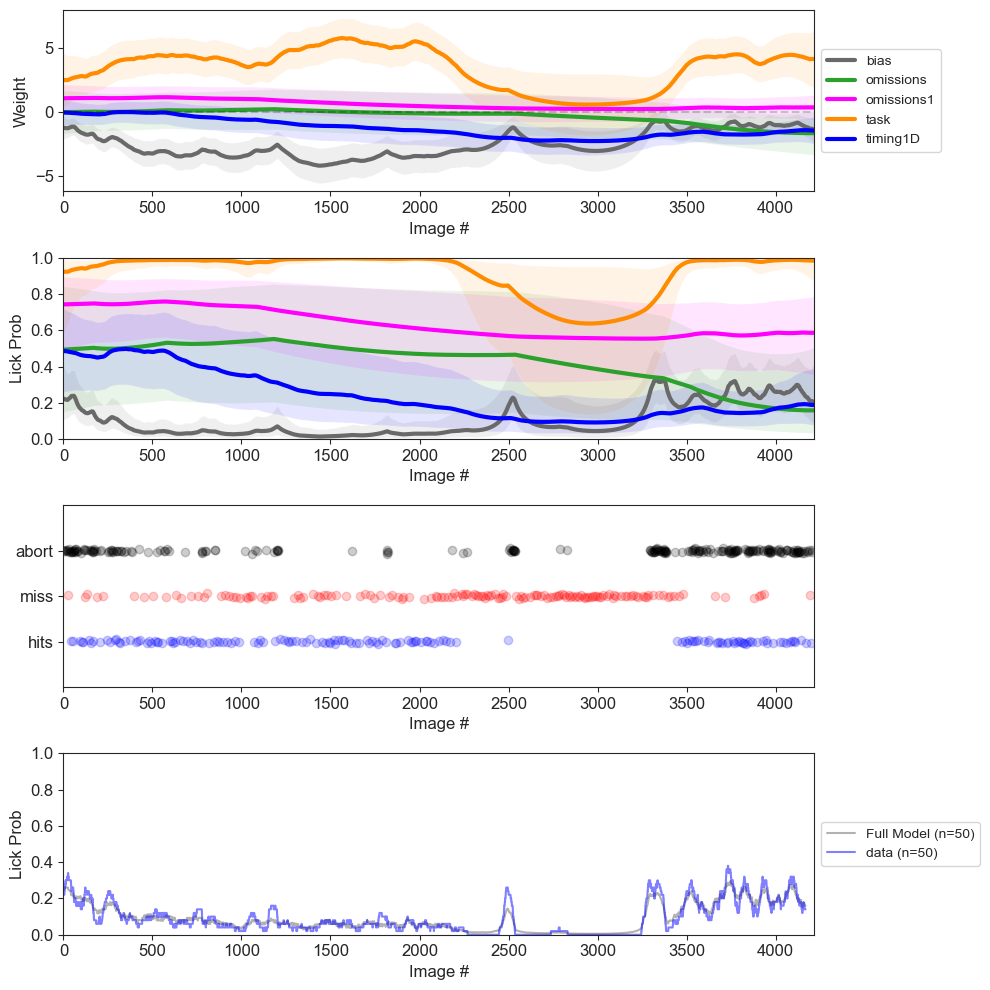

In [83]:
strategies={'bias', 'task', 'timing1D', 'omissions','omissions1'}
# strategies={'bias','task','omissions','omissions1', 'timing'}

# this is for other non-recording sessions
if np.sum(stimulus_presentations.omitted) == 0:
    strategies.remove('omissions')
    strategies.remove('omissions1')
hyp, evd, wMode, credibleInt,weights = psy_funcs.fit_weights(psydata,strategies)
ypred,ypred_each = psy_funcs.compute_ypred(psydata, wMode,weights)
psy_funcs.plot_weights(wMode, weights,psydata,errorbar=credibleInt, ypred=ypred,
    filename=f"piet_modelfit/second_trial_correction")

In [84]:
print("Cross Validation Analysis")
cross_psydata = psy.trim(psydata, 
END=int(np.floor(len(psydata['y'])/format_options['num_cv_folds'])\
*format_options['num_cv_folds'])) 
cross_results = psy_funcs.compute_cross_validation(cross_psydata, hyp, weights,
folds=format_options['num_cv_folds'])
cv_pred = psy_funcs.compute_cross_validation_ypred(cross_psydata, cross_results,ypred)

Cross Validation Analysis
running fold 9


In [85]:
cv_logli = np.array([cross_results[i]['logli'] for i in range(10)])
print(f"log evidence, whole data fit: {cv_logli.mean():.3f} pm {cv_logli.std():.3f}")

log evidence, whole data fit: -88.618 pm 10.689


CV seems to suggest that for this mice without timing it's better?

In [67]:
stim_table

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,bout_start,num_bout_start,bout_number,bout_end,num_bout_end,in_lick_bout,licked,hits,misses,aborts
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im104_r,0.250212,25.254420,25.504632,60,75,False,True,False,...,True,1,1.0,True,1,False,True,False,False,True
1,0,im104_r,0.250212,26.005057,26.255269,105,120,False,True,False,...,False,0,NaN,False,0,False,False,False,False,False
2,0,im104_r,0.250208,26.755685,27.005892,150,165,False,True,False,...,False,0,NaN,False,0,False,False,False,False,False
3,0,im104_r,0.250207,27.506307,27.756515,195,210,False,True,False,...,True,1,2.0,True,1,False,True,False,False,True
4,0,im104_r,0.250213,28.256929,28.507142,240,255,False,True,False,...,False,0,NaN,False,0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4799,0,im024_r,0.250208,3628.050892,3628.301100,216044,216059,False,True,False,...,False,0,NaN,False,0,False,False,False,False,False
4800,0,im024_r,0.250197,3628.801495,3629.051692,216089,216104,False,True,False,...,False,0,NaN,False,0,False,False,False,False,False
4801,0,im024_r,0.250220,3629.552108,3629.802328,216134,216149,False,True,False,...,False,0,NaN,False,0,False,False,False,False,False


In [40]:
licks_annot

,timestamps,frame,pre_ili,post_ili,bout_start,bout_end,bout_number,rewarded,num_rewards,bout_rewarded,bout_num_rewards
0,25.72309,91,1.40000,0.13612,True,False,1,False,0,False,0
1,25.85921,100,0.13612,2.15277,False,True,1,False,0,False,0
2,28.01198,229,2.15277,4.37988,True,True,2,False,0,False,0
3,32.39186,491,4.37988,3.12864,True,True,3,False,0,False,0
4,35.52050,679,3.12864,3.63009,True,True,4,False,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...
2985,3621.93173,215680,0.10911,0.12012,False,False,384,False,0,False,0
2986,3622.05185,215688,0.12012,0.60050,False,False,384,False,0,False,0
2987,3622.65235,215724,0.60050,0.15414,False,False,384,False,0,False,0
2988,3622.80649,215733,0.15414,0.42733,False,False,384,False,0,False,0


In [61]:
licks_annot= licks_annot[licks_annot.post_ili>.7] 
licks_after_reward = licks_annot[licks_annot.bout_rewarded]

In [62]:
licks_after_reward

,timestamps,frame,pre_ili,post_ili,bout_start,bout_end,bout_number,rewarded,num_rewards,bout_rewarded,bout_num_rewards
43,51.97736,1665,0.18218,2.09786,False,True,6,False,0,True,1
85,69.03761,2688,0.16511,1.22207,False,True,9,False,0,True,1
126,85.82146,3694,0.37732,1.33222,False,True,14,False,0,True,1
155,119.69979,5725,0.15112,0.78772,False,True,24,False,0,True,1
207,133.88658,6576,0.42432,5.91606,False,True,26,False,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...
2870,3525.98648,209928,0.11610,2.37098,False,True,360,False,0,True,1
2892,3536.56714,210563,0.13611,3.62594,False,True,363,False,0,True,1
2937,3569.11928,212514,0.13809,1.30306,False,True,373,False,0,True,1
2960,3593.91947,214001,0.61449,4.41654,False,True,378,False,0,True,1


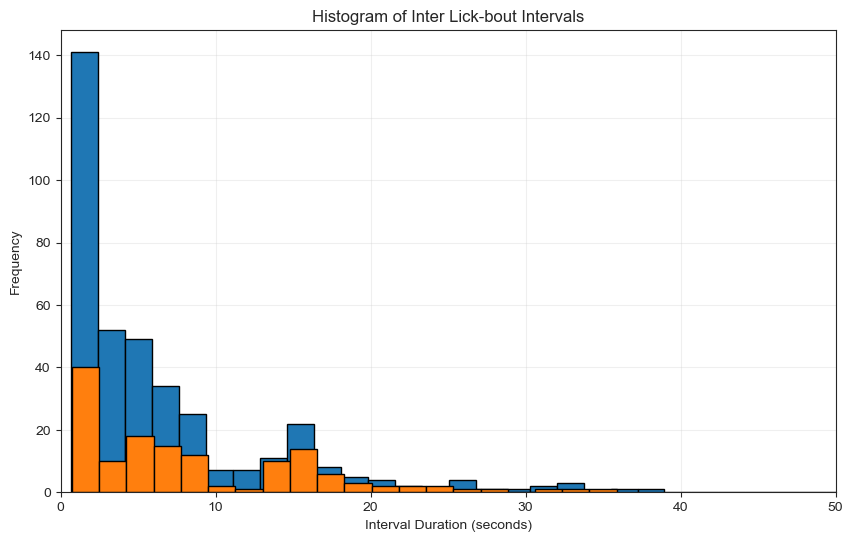

In [66]:
plt.figure(figsize=(10, 6))
plt.hist(licks_annot.post_ili, bins=200, edgecolor='black')
plt.hist(licks_after_reward.post_ili, bins=20, edgecolor='black')
plt.title('Histogram of Inter Lick-bout Intervals')
plt.xlabel('Interval Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.xlim([0, 50])
plt.show()